In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections
import requests
import base64

import ast


import nltk
from ast import literal_eval
from datetime import timedelta
import string
import statistics
import itertools

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
# from contractions import CONTRACTION_MAP
import unicodedata


from functools import reduce
import operator
import json

import sys
sys.path.append('../')
import Variables as vr

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# create loader object
L = instaloader.Instaloader()
LIST_ALL_USERS = vr.LIST_ALL_USERS

nltk.download('stopwords')
nltk.download('punkt')


USE_LOCAL_DA = True

if (not USE_LOCAL_DA):
    
    # MongoDB Database
    instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
    instagram_db = instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

else:

    # MongoDB Database
    Local_instagramClient = pymongo.MongoClient('127.0.0.1:27017',authSource='Instagram')
    instagram_db = Local_instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# https://github.com/cjhutto/vaderSentiment#citation-information

# Load impersonator posts

In [4]:
df_clusters = pd.read_csv('Dataset/cluster_impersonator_2clusters.csv')

# with open('Dataset/cluster_impersonator_2clusters.json', 'r') as f:
#     data = json.load(f)
# df_clusters = pd.DataFrame(data)

df_clusters.shape[0]

842

In [5]:
df_clusters.columns

Index(['Unnamed: 0', 'user_id', 'avg comment', 'avg like', 'avg hashtag',
       'avg caption len', 'comment', 'like', 'caption', 'community', 'hashtag',
       '_id', 'username', 'mediacount', 'followers', 'followees', 'biography',
       'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value', 'lcm', 'mcm', 'nfollower', 'nfollowee',
       'nmediacount', 'nmcm', 'n avg comment', 'n avg like', 'n avg hashtag',
       'n avg caption len', 'cluster'],
      dtype='object')

In [6]:
# df_post = pd.read_csv('Dataset/post_data.csv')
# df_post.shape[0]

# convert list represantion to real list - problem with csv load

In [7]:
def convert_representations_to_real_list(_row):
    
    _row['comment'] = ast.literal_eval(_row['comment'])
    _row['community'] = ast.literal_eval(_row['community'])
    _row['caption'] = ast.literal_eval(_row['caption'])
    _row['like'] = ast.literal_eval(_row['like'])
    _row['hashtag'] = ast.literal_eval(_row['hashtag'])

    return _row

df_clusters = df_clusters.apply(convert_representations_to_real_list, axis=1)

# clusters

In [8]:
grouped_clusters = df_clusters.groupby('cluster')
cluster_0 = grouped_clusters.get_group(0)
cluster_1 = grouped_clusters.get_group(1)

In [9]:
t0 = cluster_0[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 
          ]].mean()

t1 = cluster_1[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 
          ]].mean()

df_cluster_mean = pd.DataFrame({"cluster 0": t0, "cluster 1": t1})
df_cluster_mean

cluster 0     cluster 1
similarity_full_name       0.133993      0.413603
similarity_username        0.184778      0.401702
similarity_biography       0.181528      0.253767
similarity_photo           0.168182      0.708955
lcm                        1.000000      1.000000
mcm                        1.534091      3.330846
is_private                 0.006818      0.000000
is_verified                0.022727      0.012438
followers             101250.877273  18208.738806
followees                920.606818    729.062189
mediacount               673.320455    804.544776
nfollower                  0.002901      0.000522
nfollowee                  0.122682      0.097156
nmediacount                0.016999      0.020312
avg comment               24.959113     13.803188
avg like                1633.573069    861.612399
n avg comment              0.004871      0.002694
n avg like                 0.004636      0.002444

In [10]:
# politician
df_cluster_c0_trump = cluster_0.loc[( cluster_0['associated_username'] == vr.DONALD_TRUMP ) ] 
df_cluster_c0_obama = cluster_0.loc[( cluster_0['associated_username'] == vr.BARACK_OBAMA ) ]
df_cluster_c0_macron = cluster_0.loc[( cluster_0['associated_username'] == vr.EMMANUEL_MACRON ) ]
df_cluster_c0_johnson = cluster_0.loc[( cluster_0['associated_username'] == vr.BORIS_JOHNSON ) ]
df_cluster_c0_may = cluster_0.loc[( cluster_0['associated_username'] == vr.THERESA_MAY ) ]

# sport player
df_cluster_c0_cristiano_ronalod = cluster_0.loc[( cluster_0['associated_username'] == vr.CRISTIANO_RONALDO ) ] 
df_cluster_c0_leo_messi = cluster_0.loc[( cluster_0['associated_username'] == vr.LEOMESSI ) ]
df_cluster_c0_roger_federer = cluster_0.loc[( cluster_0['associated_username'] == vr.ROGER_FEDERER ) ]
df_cluster_c0_rafael_nadal = cluster_0.loc[( cluster_0['associated_username'] == vr.RAFAEL_NADAL ) ]
df_cluster_c0_djokovic = cluster_0.loc[( cluster_0['associated_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_cluster_c0_lady_gaga = cluster_0.loc[( cluster_0['associated_username'] == vr.LADY_GAGA )] 
df_cluster_c0_beyonce = cluster_0.loc[( cluster_0['associated_username'] == vr.BEYONCE ) ] 
df_cluster_c0_taylor_swift = cluster_0.loc[( cluster_0['associated_username'] == vr.TAYLOR_SWIFT ) ] 
df_cluster_c0_adele = cluster_0.loc[( cluster_0['associated_username'] == vr.ADELE ) ] 
df_cluster_c0_madonna = cluster_0.loc[( cluster_0['associated_username'] == vr.MADONNA ) ] 

In [11]:
list_all_usecases_cluster_c0 = [
    df_cluster_c0_trump, df_cluster_c0_obama, df_cluster_c0_macron, df_cluster_c0_johnson, df_cluster_c0_may,
    df_cluster_c0_cristiano_ronalod, df_cluster_c0_leo_messi, df_cluster_c0_rafael_nadal, df_cluster_c0_roger_federer, df_cluster_c0_djokovic,
    df_cluster_c0_lady_gaga, df_cluster_c0_beyonce, df_cluster_c0_taylor_swift, df_cluster_c0_adele, df_cluster_c0_madonna,
]

In [12]:
# politician
df_cluster_c1_trump = cluster_1.loc[( cluster_1['associated_username'] == vr.DONALD_TRUMP ) ] 
df_cluster_c1_obama = cluster_1.loc[( cluster_1['associated_username'] == vr.BARACK_OBAMA ) ]
df_cluster_c1_macron = cluster_1.loc[( cluster_1['associated_username'] == vr.EMMANUEL_MACRON ) ]
df_cluster_c1_johnson = cluster_1.loc[( cluster_1['associated_username'] == vr.BORIS_JOHNSON ) ]
df_cluster_c1_may = cluster_1.loc[( cluster_1['associated_username'] == vr.THERESA_MAY ) ]

# sport player
df_cluster_c1_cristiano_ronalod = cluster_1.loc[( cluster_1['associated_username'] == vr.CRISTIANO_RONALDO ) ] 
df_cluster_c1_leo_messi = cluster_1.loc[( cluster_1['associated_username'] == vr.LEOMESSI ) ]
df_cluster_c1_roger_federer = cluster_1.loc[( cluster_1['associated_username'] == vr.ROGER_FEDERER ) ]
df_cluster_c1_rafael_nadal = cluster_1.loc[( cluster_1['associated_username'] == vr.RAFAEL_NADAL ) ]
df_cluster_c1_djokovic = cluster_1.loc[( cluster_1['associated_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_cluster_c1_lady_gaga = cluster_1.loc[( cluster_1['associated_username'] == vr.LADY_GAGA )] 
df_cluster_c1_beyonce = cluster_1.loc[( cluster_1['associated_username'] == vr.BEYONCE ) ] 
df_cluster_c1_taylor_swift = cluster_1.loc[( cluster_1['associated_username'] == vr.TAYLOR_SWIFT ) ] 
df_cluster_c1_adele = cluster_1.loc[( cluster_1['associated_username'] == vr.ADELE ) ] 
df_cluster_c1_madonna = cluster_1.loc[( cluster_1['associated_username'] == vr.MADONNA ) ] 

In [13]:
list_all_usecases_cluster_c1 = [
    df_cluster_c1_trump, df_cluster_c1_obama, df_cluster_c1_macron, df_cluster_c1_johnson, df_cluster_c1_may,
    df_cluster_c1_cristiano_ronalod, df_cluster_c1_leo_messi, df_cluster_c1_rafael_nadal, df_cluster_c1_roger_federer, df_cluster_c1_djokovic,
    df_cluster_c1_lady_gaga, df_cluster_c1_beyonce, df_cluster_c1_taylor_swift, df_cluster_c1_adele, df_cluster_c1_madonna,
]

# extend Dataframe

In [14]:
df_clusters.columns

Index(['Unnamed: 0', 'user_id', 'avg comment', 'avg like', 'avg hashtag',
       'avg caption len', 'comment', 'like', 'caption', 'community', 'hashtag',
       '_id', 'username', 'mediacount', 'followers', 'followees', 'biography',
       'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value', 'lcm', 'mcm', 'nfollower', 'nfollowee',
       'nmediacount', 'nmcm', 'n avg comment', 'n avg like', 'n avg hashtag',
       'n avg caption len', 'cluster'],
      dtype='object')

In [15]:
df_clusters['hashtag'][0][0]

[]

In [16]:
def extended_cluster_for_topic(_df):
    
    list_ids = []
    list_captions = []
    list_community = []
    list_associated_username = []
    list_cluster = []
    list_hashtag = []
    
    
    for index, row in _df.iterrows():
        for item in row['caption']:
            list_ids.append(row['user_id'])
            list_captions.append(item)
            list_community.append(row['community'][0])
            list_associated_username.append(row['associated_username'])
            list_cluster.append(row['cluster'])
            
        for item in row['hashtag']:  
            list_hashtag.append(item)
            
    
    df_final = pd.DataFrame({"user_id": list_ids, "caption": list_captions})
    df_final['community'] = list_community
    df_final['associated_username'] = list_associated_username
    df_final['cluster'] = list_cluster
    df_final['hashtag'] = list_hashtag
    return df_final

In [17]:
df_clusters_extended = extended_cluster_for_topic(df_clusters)
df_clusters_extended.head()

user_id                                            caption    community  \
0  3502553                                  LA I’ll miss ya 🍂     musician   
1  3502553  You will always have a special place in my hea...     musician   
2  3502553  Thank u universe,\n\n#thanksgiving2019\n#tbt #...     musician   
3  3502553  Sup IG it’s been a while 😛\n.\n.\n@mshairandhu...     musician   
4  5139534  #RogerFederer @rogerfederer #RF #Federer #Supp...  sportplayer   

  associated_username  cluster  \
0             madonna        0   
1             madonna        0   
2             madonna        0   
3             madonna        0   
4        rogerfederer        0   

                                             hashtag  
0                                                 []  
1        [hbdbritney, 2008, circus, bevelgamestrong]  
2                   [thanksgiving2019, tbt, okinawa]  
3                                                 []  
4  [rogerfederer, rf, federer, supporttheswiss, a...

In [18]:
# cluster_0[cluster_0['associated_username'] == "emmanuelmacron"].head(100)
# cluster_1.head(5)

In [19]:
grouped_clusters_extended = df_clusters_extended.groupby('cluster')
extended_cluster_0 = grouped_clusters_extended.get_group(0)
extended_cluster_1 = grouped_clusters_extended.get_group(1)

In [20]:
extended_cluster_0_politician = extended_cluster_0[extended_cluster_0['community'] == 'politician']
extended_cluster_0_sportplayer = extended_cluster_0[extended_cluster_0['community'] == 'sportplayer']
extended_cluster_0_musician = extended_cluster_0[extended_cluster_0['community'] == 'musician']

extended_cluster_1_politician = extended_cluster_1[extended_cluster_1['community'] == 'politician']
extended_cluster_1_sportplayer = extended_cluster_1[extended_cluster_1['community'] == 'sportplayer']
extended_cluster_1_musician = extended_cluster_1[extended_cluster_1['community'] == 'musician']

In [21]:
extended_cluster_0_trump = extended_cluster_0[extended_cluster_0['associated_username'] == vr.DONALD_TRUMP]
extended_cluster_0_obama = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BARACK_OBAMA]
extended_cluster_0_macron = extended_cluster_0[extended_cluster_0['associated_username'] == vr.EMMANUEL_MACRON]
extended_cluster_0_may = extended_cluster_0[extended_cluster_0['associated_username'] == vr.THERESA_MAY]
extended_cluster_0_johnson = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BORIS_JOHNSON]

extended_cluster_0_messi = extended_cluster_0[extended_cluster_0['associated_username'] == vr.LEOMESSI]
extended_cluster_0_ronaldo = extended_cluster_0[extended_cluster_0['associated_username'] == vr.CRISTIANO_RONALDO]
extended_cluster_0_nadal = extended_cluster_0[extended_cluster_0['associated_username'] == vr.RAFAEL_NADAL]
extended_cluster_0_federer = extended_cluster_0[extended_cluster_0['associated_username'] == vr.ROGER_FEDERER]
extended_cluster_0_djokovic = extended_cluster_0[extended_cluster_0['associated_username'] == vr.NOVAK_DJOKOVIC]

extended_cluster_0_ladygaga = extended_cluster_0[extended_cluster_0['associated_username'] == vr.LADY_GAGA]
extended_cluster_0_madonna = extended_cluster_0[extended_cluster_0['associated_username'] == vr.MADONNA]
extended_cluster_0_taylorswift = extended_cluster_0[extended_cluster_0['associated_username'] == vr.TAYLOR_SWIFT]
extended_cluster_0_beyonce = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BEYONCE]
extended_cluster_0_adele = extended_cluster_0[extended_cluster_0['associated_username'] == vr.ADELE]


# cluster 1
extended_cluster_1_trump = extended_cluster_1[extended_cluster_1['associated_username'] == vr.DONALD_TRUMP]
extended_cluster_1_obama = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BARACK_OBAMA]
extended_cluster_1_macron = extended_cluster_1[extended_cluster_1['associated_username'] == vr.EMMANUEL_MACRON]
extended_cluster_1_may = extended_cluster_1[extended_cluster_1['associated_username'] == vr.THERESA_MAY]
extended_cluster_1_johnson = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BORIS_JOHNSON]

extended_cluster_1_messi = extended_cluster_1[extended_cluster_1['associated_username'] == vr.LEOMESSI]
extended_cluster_1_ronaldo = extended_cluster_1[extended_cluster_1['associated_username'] == vr.CRISTIANO_RONALDO]
extended_cluster_1_nadal = extended_cluster_1[extended_cluster_1['associated_username'] == vr.RAFAEL_NADAL]
extended_cluster_1_federer = extended_cluster_1[extended_cluster_1['associated_username'] == vr.ROGER_FEDERER]
extended_cluster_1_djokovic = extended_cluster_1[extended_cluster_1['associated_username'] == vr.NOVAK_DJOKOVIC]

extended_cluster_1_ladygaga = extended_cluster_1[extended_cluster_1['associated_username'] == vr.LADY_GAGA]
extended_cluster_1_madonna = extended_cluster_1[extended_cluster_1['associated_username'] == vr.MADONNA]
extended_cluster_1_taylorswift = extended_cluster_1[extended_cluster_1['associated_username'] == vr.TAYLOR_SWIFT]
extended_cluster_1_beyonce = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BEYONCE]
extended_cluster_1_adele = extended_cluster_1[extended_cluster_1['associated_username'] == vr.ADELE]

In [22]:
extended_cluster_0.columns

Index(['user_id', 'caption', 'community', 'associated_username', 'cluster',
       'hashtag'],
      dtype='object')

# Hashtags

In [23]:
def convert_hashtags(_row):

    _row['hashtag raw'] = ' '.join(_row['hashtag'])
    return _row

df_clusters_extended = df_clusters_extended.apply(convert_hashtags, axis=1)
extended_cluster_0 = extended_cluster_0.apply(convert_hashtags, axis=1)
extended_cluster_1 = extended_cluster_1.apply(convert_hashtags, axis=1)

In [24]:
# extended_cluster_0_politician['hashtag'].tolist()
# ','.join(list(itertools.chain.from_iterable(_df['hashtag'])))
# ','.join(list(itertools.chain.from_iterable(extended_cluster_0_politician['hashtag']))).split()
# ','.join(list(itertools.chain.from_iterable(extended_cluster_0_politician['hashtag']))).split()

In [25]:
def get_most_frequent_hashtag_plot(_df, _num):
    hashtag = _df['hashtag'].tolist()
    hashtag = list(itertools.chain.from_iterable(hashtag))
    counter = collections.Counter(hashtag)
    mc = counter.most_common(_num)
    
    f_string = ""
    for item in mc:
        f_string += (str(item[0])+ " ") * item[1]
        
    return f_string

In [26]:
from wordcloud import (WordCloud, get_single_color_func)

def get_wordcloud_plot_colored(_df, _df2, _hashtag, _width, _height, _color):
    
    class SimpleGroupedColorFunc(object):

        def __init__(self, color_to_words, default_color):
            self.word_to_color = {word: color
                                  for (color, words) in color_to_words.items()
                                  for word in words}

            self.default_color = default_color

        def __call__(self, word, **kwargs):
            return self.word_to_color.get(word, self.default_color)


    class GroupedColorFunc(object):
        def __init__(self, color_to_words, default_color):
            self.color_func_to_words = [
                (get_single_color_func(color), set(words))
                for (color, words) in color_to_words.items()]

            self.default_color_func = get_single_color_func(default_color)

        def get_color_func(self, word):
            """Returns a single_color_func associated with the word"""
            try:
                color_func = next(
                    color_func for (color_func, words) in self.color_func_to_words
                    if word in words)
            except StopIteration:
                color_func = self.default_color_func

            return color_func

        def __call__(self, word, **kwargs):
            return self.get_color_func(word)(word, **kwargs)

    
    text1 = ' '.join(list(_df['hashtag raw'].values))
    text2 = ' '.join(list(_df2['hashtag raw'].values))
    text = text1 + text2
    
    d1 = get_most_frequent_hashtag_plot(_df, 200)
    d2 = get_most_frequent_hashtag_plot(_df2, 200)
    df = d1 + d2

    # Since the text is small collocations are turned off and text is lower-cased
    wc = WordCloud(collocations=False, background_color="white", max_words=500,).generate(text.lower())

    color_to_words = {
        # words below will be colored with a green single color function
        'red': list(itertools.chain.from_iterable(_df2['hashtag'])),
        'blue' : list(itertools.chain.from_iterable(_df['hashtag'])),

        
    }

    # Words that are not in any of the color_to_words values
    # will be colored with a grey single color function
    default_color = 'grey'

    # Create a color function with single tone
    # grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

    # Create a color function with multiple tones
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    # Apply our color function
    wc.recolor(color_func=grouped_color_func)

    # Plot
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# #     plt.savefig('plot_MLearning13_P9.pdf',bbox_inches='tight',pad_inches=0.1)


In [27]:
# pll = get_wordcloud_plot_colored(extended_cluster_0_politician, extended_cluster_1_politician, vr.HASHTAG_POLITICIAN, 11, 4, "gist_gray_r")

In [28]:
# pll = get_wordcloud_plot_colored(extended_cluster_0_sportplayer, extended_cluster_1_sportplayer, vr.HASHTAG_POLITICIAN, 11, 4, "gist_gray_r")

In [29]:
# pll = get_wordcloud_plot_colored(extended_cluster_0_musician, extended_cluster_1_musician, vr.HASHTAG_POLITICIAN, 11, 4, "gist_gray_r")

In [30]:
# wordcloud of hashtags
def get_wordcloud_plot(_df, _hashtag, _width, _height, _color, _num):
    
    # all posts & all hashtags
    hashtag = _df["hashtag"].tolist()
    hashtag = list(itertools.chain.from_iterable(hashtag))
    counter = collections.Counter(hashtag)
    
    for item in _hashtag:
        del counter[item]
    
    wordcloud = WordCloud(width = _width*100, height = _height*100, background_color="white", max_words=_num, contour_width=3, colormap=_color).generate_from_frequencies(counter)
    plt.figure(figsize=[_width,_height]) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off")
    
    return plt

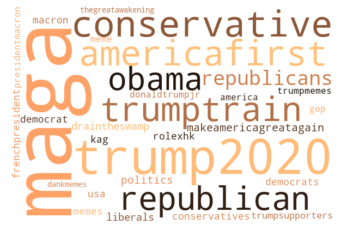

In [31]:
list_remove = ['trump']
pll = get_wordcloud_plot(extended_cluster_0_politician, vr.HASHTAG_POLITICIAN + list_remove, 6, 4, matplotlib.cm.copper, 30)
pll.savefig('plot_18Cluster_P1.pdf',bbox_inches='tight')

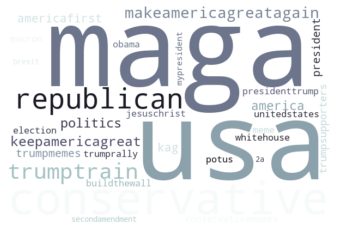

In [32]:
list_remove = ['trump', 'trump2020']
pll = get_wordcloud_plot(extended_cluster_1_politician, vr.HASHTAG_POLITICIAN + list_remove, 6, 4, matplotlib.cm.bone, 30)
pll.savefig('plot_18Cluster_P2.pdf',bbox_inches='tight')

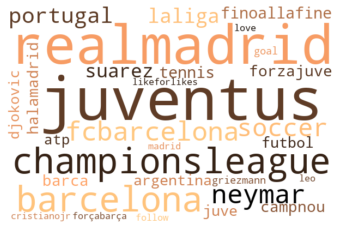

In [33]:
list_remove = ['ronaldo', 'messi', 'cristiano', 'cr7', 'football', 'lionelmessi']
pll = get_wordcloud_plot(extended_cluster_0_sportplayer, vr.HASHTAG_SPORT + list_remove, 6, 4, matplotlib.cm.copper, 30)
pll.savefig('plot_18Cluster_P3.pdf',bbox_inches='tight')

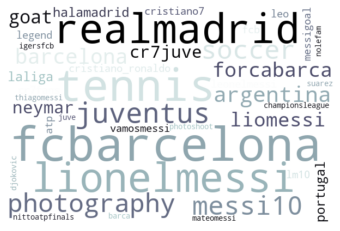

In [34]:
list_remove = ['ronaldo', 'messi', 'cristiano', 'cr7', 'football', ]
pll = get_wordcloud_plot(extended_cluster_1_sportplayer, vr.HASHTAG_SPORT + list_remove, 6, 4, matplotlib.cm.bone, 40)
pll.savefig('plot_18Cluster_P4.pdf',bbox_inches='tight')

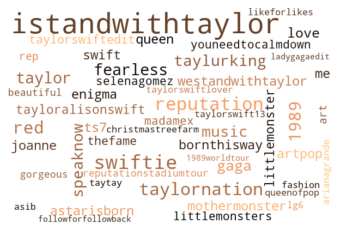

In [35]:
list_remove = ['swifties', 'lover']
pll = get_wordcloud_plot(extended_cluster_0_musician, vr.HASHTAG_MUSICIAN + list_remove, 6, 4, matplotlib.cm.copper, 50)
pll.savefig('plot_18Cluster_P5.pdf',bbox_inches='tight')

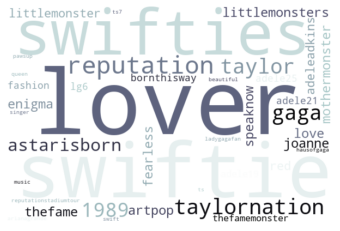

In [36]:
list_remove = []
pll = get_wordcloud_plot(extended_cluster_1_musician, vr.HASHTAG_MUSICIAN + list_remove, 6, 4, matplotlib.cm.bone, 40)
pll.savefig('plot_18Cluster_P6.pdf',bbox_inches='tight')

# Most frequent Hashtag - Table

In [37]:
def get_most_frequent_hashtag(_df, _num):
    hashtag = _df['hashtag'].tolist()
    hashtag = list(itertools.chain.from_iterable(hashtag))
    counter = collections.Counter(hashtag)
    return counter.most_common(_num)

In [38]:
get_most_frequent_hashtag(extended_cluster_0_madonna, 20)

[('madonna', 121),
 ('madamex', 85),
 ('queenofpop', 50),
 ('madamextour', 40),
 ('music', 36),
 ('queen', 29),
 ('80s', 21),
 ('art', 20),
 ('likeforfollow', 20),
 ('lgbt', 19),
 ('90s', 19),
 ('themet', 17),
 ('madame', 16),
 ('artist', 14),
 ('fashion', 13),
 ('likeavirgin', 13),
 ('icon', 12),
 ('instagood', 12),
 ('divastopfive', 12),
 ('repost', 11)]

In [39]:
get_most_frequent_hashtag(extended_cluster_1_madonna, 20)

[('madonna', 91),
 ('madonnafans', 50),
 ('queenofpop', 41),
 ('madamex', 34),
 ('madamextour', 21),
 ('icon', 21),
 ('madonnafan', 20),
 ('madonnafamily', 16),
 ('madonna80s', 15),
 ('iconic', 15),
 ('queen', 15),
 ('80smadonna', 14),
 ('beauty', 13),
 ('legend', 13),
 ('fashion', 12),
 ('madonnamusic', 12),
 ('madonnalove', 12),
 ('madonnacollection', 11),
 ('madonnastyle', 11),
 ('bitchimmadonna', 11)]

# Hashtag Sentiment score

In [40]:
# https://github.com/cjhutto/vaderSentiment#citation-information
#https://github.com/marcharper/python-ternary/blob/master/examples/Ternary-Examples.ipynb

In [41]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from gensim import corpora, models
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kooshazarei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
nlp = spacy.load('en', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [43]:
import wordninja
def split_hashtags(_row):

    _row['hashtag raw splitted'] = ' '.join(wordninja.split(_row['hashtag raw']))

    return _row

df_clusters_extended = df_clusters_extended.apply(split_hashtags, axis=1)

In [44]:
def clean_text(_row):
    
    text = _row['hashtag raw splitted']
    
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    text = re.sub('\S*@\S*\s?', '', text)  # remove emails
    text = re.sub('\s+', ' ', text)  # remove newline chars
    text = re.sub("\'", "", text)  # remove single quotes

    #emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation
    text = re.sub('[,\.!?]', '', text)

    # Convert the titles to lowercase
    text = text.lower()

    _row['hashtag raw splitted clean'] = text
        
    return _row

df_clusters_extended = df_clusters_extended.apply(clean_text, axis=1)

In [45]:
corpus = df_clusters_extended['hashtag raw splitted clean'].tolist()

In [46]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn(emoticons=True)

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

    
# sentiment statistics per news category
df = pd.DataFrame([ list(df_clusters_extended['associated_username']), list(df_clusters_extended['community']), list(df_clusters_extended['cluster']), sentiment_scores, sentiment_category]).T
df.columns = ['use case', 'community', 'cluster', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df
df.groupby(by=['cluster']).describe()

sentiment_score                                                
                  count      mean       std   min  25%  50%  75%    max
cluster                                                                
0                4204.0  3.722169  7.660061 -19.0  0.0  0.0  5.0   55.0
1                3870.0  3.528941  8.946038 -12.0  0.0  0.0  4.0  120.0

In [47]:
def remove_zeros(_row):

    _row['sentiment_score_wz'] = _row['sentiment_score']
    
    if (_row['sentiment_score'] == 0):
            _row['sentiment_score_wz'] = None
            
    return _row

df = df.apply(remove_zeros, axis=1)

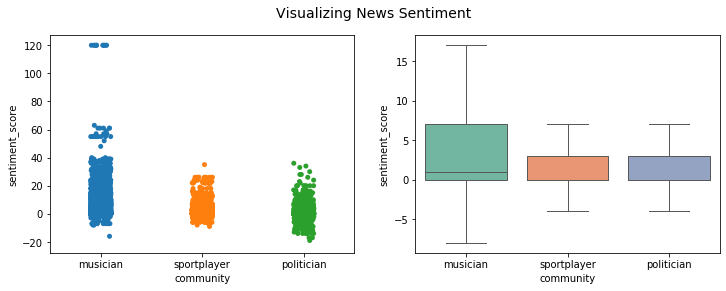

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sp = sns.stripplot(x='community', y="sentiment_score", data=df, ax=ax1)

bp = sns.boxplot(x='community', y="sentiment_score", data=df, palette="Set2", ax=ax2, showfliers=False, linewidth=1,)

# bp.set_yscale('log')

t = f.suptitle('Visualizing News Sentiment', fontsize=14)

In [49]:
def remove_zero_df(_df, _username):

    _df[_df['use case'] == _username]['sentiment_score'] = _df[_df['use case'] == _username]['sentiment_score'].map({0: nan})

#     _df = _df[_df['use case'] == _username]['sentiment_score'].replace(0, nan, inplace=True)
            
    return _df

In [50]:
df.columns

Index(['use case', 'community', 'cluster', 'sentiment_score',
       'sentiment_category', 'sentiment_score_wz'],
      dtype='object')

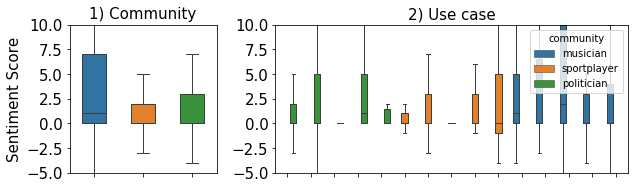

In [51]:
def plot_7():
    
    fig = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
    first_plt = plt.subplot(grid[0, 0])
    sec_plt = plt.subplot(grid[0, 1:])
    

    df_cluster_1 = df[df['cluster'] == 0]
    
#     df_cluster_1 = remove_zero_df(df_cluster_1, 'emmanuelmacron')
#     df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron']['sentiment_score'].replace(0, np.nan)
    
#     print(df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron'])
#     print(df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron']['sentiment_score'].replace(0,nan))

    sp = sns.boxplot(x='community', y="sentiment_score",data=df_cluster_1, ax=first_plt,showfliers=False, linewidth=1, width=0.5)    
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("1) Community")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.axes.set_ylim([-5,10])
    sp.set(xticklabels=[])
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)


    sp = sns.boxplot(x='use case', y="sentiment_score", hue='community',data=df_cluster_1, ax=sec_plt, showfliers=False, linewidth=1,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    
        
    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel(" ")
    sp.set_xlabel("")
    sp.set_title("2) Use case")
    sp.xaxis.set_tick_params(rotation=-90)
#     ax.axes.set_xlim([0,1])
    sp.axes.set_ylim([-5,10])
    sp.set(xticklabels=[])
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

    plt.savefig("plot_18Cluster_P7.pdf", bbox_inches='tight')


plot_7()

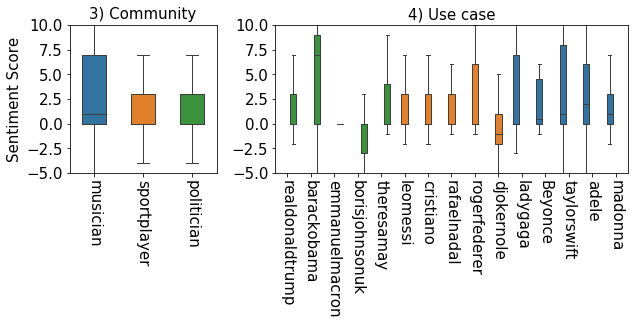

In [52]:
def plot_8():
    
    fig = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
    first_plt = plt.subplot(grid[0, 0])
    sec_plt = plt.subplot(grid[0, 1:])

    df_cluster_1 = df[df['cluster'] == 1]

    sp = sns.boxplot(x='community', y="sentiment_score",data=df_cluster_1, ax=first_plt,showfliers=False, linewidth=1, width=0.5)    
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("3) Community")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.axes.set_ylim([-5,10])
#     sp.set(xticklabels=[])
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)


    sp = sns.boxplot(x='use case', y="sentiment_score", hue='community',data=df_cluster_1, ax=sec_plt, showfliers=False, linewidth=1,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    
        
    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel(" ")
    sp.set_xlabel("")
    sp.set_title("4) Use case")
    sp.xaxis.set_tick_params(rotation=-90)
#     ax.axes.set_xlim([0,1])
    sp.axes.set_ylim([-5,10])
    sp.get_legend().set_visible(False)
#     sp.set(xticklabels=[])
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

    plt.savefig("plot_18Cluster_P8.pdf", bbox_inches='tight')


plot_8()

# method two

In [53]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [54]:
def get_vader_sentiment(_row):
    temp = _row['hashtag raw splitted clean']
    _row['vader'] = analyzer.polarity_scores(temp)
    return _row

df_clusters_extended = df_clusters_extended.apply(get_vader_sentiment, axis=1)

In [55]:
def extend_vader(_row):
    
    item = _row['vader']
    
    _row['vader_pos'] = item['pos']
    _row['vader_neu'] = item['neu']
    _row['vader_neg'] = item['neg']
    _row['vader_compound'] = item['compound']
    
    return _row

df_clusters_extended = df_clusters_extended.apply(extend_vader, axis=1)

In [56]:
def transform_compound_to_cat(_row):    

    if _row["vader_compound"] >= 0.05:
        _row['vader_cat'] = "positive"
        
    elif _row["vader_compound"] <= -0.05:
        _row['vader_cat'] = "negative"
        
    else:
        _row['vader_cat'] = "neutral"
    
    return _row

df_clusters_extended = df_clusters_extended.apply(transform_compound_to_cat, axis=1)

In [57]:
grouped_df_clusters_extended = df_clusters_extended.groupby('cluster')
cluster_0 = grouped_df_clusters_extended.get_group(0)
cluster_1 = grouped_df_clusters_extended.get_group(1)

In [58]:
cluster_0[['caption', 'vader_pos', 'vader_neu', 'vader_neg', 'vader_compound', 'vader_cat']].head()

caption  vader_pos  vader_neu  \
0                                  LA I’ll miss ya 🍂      0.000      0.000   
1  You will always have a special place in my hea...      0.355      0.645   
2  Thank u universe,\n\n#thanksgiving2019\n#tbt #...      0.000      1.000   
3  Sup IG it’s been a while 😛\n.\n.\n@mshairandhu...      0.000      0.000   
4  #RogerFederer @rogerfederer #RF #Federer #Supp...      0.162      0.838   

   vader_neg  vader_compound vader_cat  
0        0.0          0.0000   neutral  
1        0.0          0.5106  positive  
2        0.0          0.0000   neutral  
3        0.0          0.0000   neutral  
4        0.0          0.4019  positive

In [59]:
def get_points(_df):
    
    list_vader = _df['vader'].tolist()
    points = []
    
    for item in list_vader:
        x = item['pos']
        y = item['neu']
        z = item['neg']
        points.append((x,y,z))
        
    return points

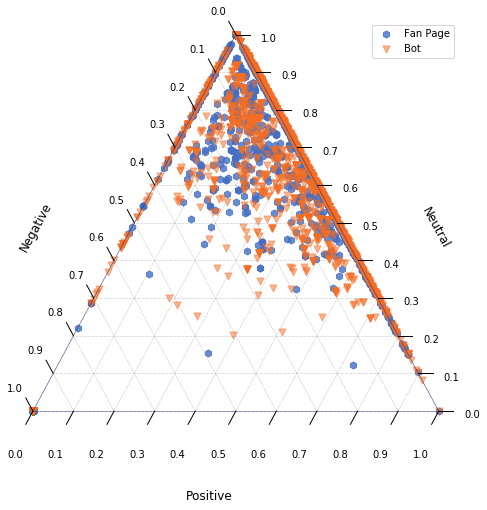

In [60]:
import ternary
import random

def plot_9():

    scale = 1
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(8, 8)


    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5, alpha=0.5)
    tax.gridlines(color="blue", multiple=5)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.24

    # tax.right_corner_label("X", fontsize=fontsize)
    # tax.top_corner_label("Y", fontsize=fontsize)
    # tax.left_corner_label("Z", fontsize=fontsize)

    tax.left_axis_label("Negative", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Neutral", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Positive", fontsize=fontsize, offset=offset)

    n_size = 50
    ["h" , "X" , "v" , "o"]

    points = get_points(cluster_1)
    tax.scatter(points, marker='h', s=n_size, color=vr.COLORS_CLUSTERS[0], label="Fan Page", alpha=0.8)

    points = get_points(cluster_0)
    tax.scatter(points, marker='v', s=n_size, color=vr.COLOR_SPORTSARTS, label="Bot", alpha=0.5)



    tax.legend()


    # tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="gray")
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.035)

    tax.get_axes().axis('off')

    tax.show()

    fig.savefig("plot_18Cluster_P9.pdf", bbox_inches='tight')

plot_9()

In [61]:
 def get_avg_sentiment(_df):
    
    def get_vader_sentiment(_row):
        temp = _row['caption']
        _row['vader'] = analyzer.polarity_scores(temp)
        return _row

    #filter nan
    temp = _df.dropna(subset=['caption'])
    temp = temp.apply(get_vader_sentiment, axis=1)
    
    
    # get sentiment list
    list_pos = []
    list_neg = []
    list_neu = []
    list_compound = []

    for index, row in temp.iterrows():
        list_pos.append(row['vader']['pos'])
        list_neg.append(row['vader']['neg'])
        list_neu.append(row['vader']['neu'])
        list_compound.append(row['vader']['compound'])

    return list_pos, list_neg, list_neu, list_compound

In [62]:
def get_polarity_meadn(_df):
    lp, ln, lne, lc = get_avg_sentiment(_df)  
    print("pos: " + str(mean(lp)))
    print("neu: " + str(mean(lne)))
    print("neg: " + str(mean(ln)))
    
    print("compount: " + str(mean(lc)))

In [63]:
get_polarity_meadn(extended_cluster_0)  

pos: 0.10820997566909978
neu: 0.864383211678832
neg: 0.02522238442822385
compount: 0.2386482481751825


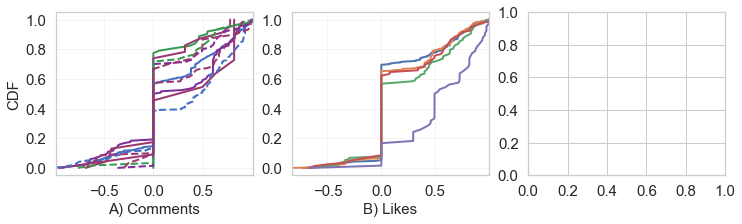

In [64]:
# 
def plot_2():
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    
    ALL_DF = [extended_cluster_0_trump, 
              extended_cluster_0_obama, 
              extended_cluster_0_macron,
              extended_cluster_0_may,
              extended_cluster_0_johnson,
              
              extended_cluster_1_trump, 
              extended_cluster_1_obama, 
              extended_cluster_1_macron,
              extended_cluster_1_may,
              extended_cluster_1_johnson,
             ]
    
    LINE_STYLE = [ '-', '-', '-', '-', '-',
        '--', '--', '--', '--', '--',
    ]
    
    LIST_COLOR = [
        vr.DONALD_TRUMP_COLOR, vr.BARACK_OBAMA_COLOR, vr.EMMANUEL_MACRON_COLOR, vr.THERESA_MAY_COLOR, vr.BORIS_JOHNSON_COLOR,
        vr.DONALD_TRUMP_COLOR, vr.BARACK_OBAMA_COLOR, vr.EMMANUEL_MACRON_COLOR, vr.THERESA_MAY_COLOR, vr.BORIS_JOHNSON_COLOR,
    ]
    
    counter = 0
    
    for item in ALL_DF:
        if (item.shape[0] != 0):
                
            lp, ln, lne, lc = get_avg_sentiment(item)  
            
            ser = pd.Series(lc)
            ser = ser.sort_values()
            ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser) 
            ax = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=axes[0], legend=False, linestyle=LINE_STYLE[counter], c=LIST_COLOR[counter])#, label=vr.NAME_COMMUNITIES[counter], c=vr.COLORS_COMMUNITIES[counter])
            
        counter += 1

#     ax.axes.set_xlim([0,1])
#     ax.axes.set_ylim([0.79,1.01])
    ax.set_ylabel("CDF")
    ax.set_xlabel("A) Comments")
#     ax.set_title(" ")
    ax.grid(True, which='both', linestyle='-', alpha=0.2)
    
    
    
    
    
    ALL_DF = [extended_cluster_0_messi, 
              extended_cluster_0_ronaldo, 
              extended_cluster_0_nadal,
              extended_cluster_0_federer,
              extended_cluster_0_djokovic,
             ]
    
    counter = 0
    for item in ALL_DF:
        if (item.shape[0] != 0):
            
            lp, ln, lne, lc = get_avg_sentiment(item)  
                
            ser = pd.Series(lc)
            ser = ser.sort_values()
            ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser) 
            ax = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=axes[1], legend=False)#, label=vr.NAME_COMMUNITIES[counter], c=vr.COLORS_COMMUNITIES[counter])
            
        counter += 1

#     ax.axes.set_xlim([0,1])
#     ax.axes.set_ylim([0.79,1.01])
#     ax.set_ylabel("CDF")
    ax.set_xlabel("B) Likes")
    ax.grid(True, which='both', linestyle='-', alpha=0.2)
    
    
    
    
#     counter = 0
#     for item in ALL_DF:
#         if (item.shape[0] != 0):
                
#             ser = item[['post_owner_mediacount']].copy()
#             ser = ser.sort_values(by='post_owner_mediacount')
#             ser[len(ser)] = ser.iloc[-1]
#             cum_dist = np.linspace(0.,1.,len(ser))
#             ser_cdf = pd.Series(cum_dist, index=ser) 
#             ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=axes[2], legend=True, label=vr.NAME_COMMUNITIES[counter], c=vr.COLORS_COMMUNITIES[counter])
            
#         counter += 1

# #     ax.axes.set_xlim([0,1])
# #     ax.axes.set_ylim([0.79,1.01])
# #     ax.set_ylabel("CDF")
#     ax.set_xlabel("C) Mediacount")
#     ax.grid(True, which='both', linestyle='-', alpha=0.2)
    

    
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

#     t = plt.suptitle('Similarity in Profile Features', fontsize=15)
    
#     plt.savefig("plot_02distribution_P2.pdf", bbox_inches='tight')
    
plot_2()

# Find Correlation

In [65]:
extended_cluster_0_trump = extended_cluster_0[extended_cluster_0['associated_username'] == vr.DONALD_TRUMP]
extended_cluster_0_obama = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BARACK_OBAMA]
extended_cluster_0_macron = extended_cluster_0[extended_cluster_0['associated_username'] == vr.EMMANUEL_MACRON]
extended_cluster_0_may = extended_cluster_0[extended_cluster_0['associated_username'] == vr.THERESA_MAY]
extended_cluster_0_johnson = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BORIS_JOHNSON]

extended_cluster_0_messi = extended_cluster_0[extended_cluster_0['associated_username'] == vr.LEOMESSI]
extended_cluster_0_ronaldo = extended_cluster_0[extended_cluster_0['associated_username'] == vr.CRISTIANO_RONALDO]
extended_cluster_0_nadal = extended_cluster_0[extended_cluster_0['associated_username'] == vr.RAFAEL_NADAL]
extended_cluster_0_federer = extended_cluster_0[extended_cluster_0['associated_username'] == vr.ROGER_FEDERER]
extended_cluster_0_djokovic = extended_cluster_0[extended_cluster_0['associated_username'] == vr.NOVAK_DJOKOVIC]

extended_cluster_0_ladygaga = extended_cluster_0[extended_cluster_0['associated_username'] == vr.LADY_GAGA]
extended_cluster_0_madonna = extended_cluster_0[extended_cluster_0['associated_username'] == vr.MADONNA]
extended_cluster_0_taylorswift = extended_cluster_0[extended_cluster_0['associated_username'] == vr.TAYLOR_SWIFT]
extended_cluster_0_beyonce = extended_cluster_0[extended_cluster_0['associated_username'] == vr.BEYONCE]
extended_cluster_0_adele = extended_cluster_0[extended_cluster_0['associated_username'] == vr.ADELE]


# cluster 1
extended_cluster_1_trump = extended_cluster_1[extended_cluster_1['associated_username'] == vr.DONALD_TRUMP]
extended_cluster_1_obama = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BARACK_OBAMA]
extended_cluster_1_macron = extended_cluster_1[extended_cluster_1['associated_username'] == vr.EMMANUEL_MACRON]
extended_cluster_1_may = extended_cluster_1[extended_cluster_1['associated_username'] == vr.THERESA_MAY]
extended_cluster_1_johnson = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BORIS_JOHNSON]

extended_cluster_1_messi = extended_cluster_1[extended_cluster_1['associated_username'] == vr.LEOMESSI]
extended_cluster_1_ronaldo = extended_cluster_1[extended_cluster_1['associated_username'] == vr.CRISTIANO_RONALDO]
extended_cluster_1_nadal = extended_cluster_1[extended_cluster_1['associated_username'] == vr.RAFAEL_NADAL]
extended_cluster_1_federer = extended_cluster_1[extended_cluster_1['associated_username'] == vr.ROGER_FEDERER]
extended_cluster_1_djokovic = extended_cluster_1[extended_cluster_1['associated_username'] == vr.NOVAK_DJOKOVIC]

extended_cluster_1_ladygaga = extended_cluster_1[extended_cluster_1['associated_username'] == vr.LADY_GAGA]
extended_cluster_1_madonna = extended_cluster_1[extended_cluster_1['associated_username'] == vr.MADONNA]
extended_cluster_1_taylorswift = extended_cluster_1[extended_cluster_1['associated_username'] == vr.TAYLOR_SWIFT]
extended_cluster_1_beyonce = extended_cluster_1[extended_cluster_1['associated_username'] == vr.BEYONCE]
extended_cluster_1_adele = extended_cluster_1[extended_cluster_1['associated_username'] == vr.ADELE]

In [66]:
text_t1 = extended_cluster_1_trump['hashtag'].sum()
text_t1
counter1=collections.Counter(text_t1)
# print(counter)
df_t1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index()
df_t1 = df_t1.rename(columns={'index':'event', 0:'fan'})
# df_t1

In [67]:
text_t = extended_cluster_0_trump['hashtag'].sum()
text_t
counter=collections.Counter(text_t)
# print(counter)
df_t = pd.DataFrame.from_dict(counter, orient='index').reset_index()
df_t = df_t.rename(columns={'index':'event', 0:'bot'})
# df_t

In [68]:
# df_resutl = pd.concat([df_t, df_t1], axis=1, join='inner')
df_resutl = pd.merge(df_t, df_t1,how='outer', on=['event'])
df_resutl.fillna(0, inplace=True)
df_resutl = df_resutl.set_index("event")
# df_resutl

In [69]:
df_resutl_sort = df_resutl.sort_values(by=['bot'], ascending=False)
# df_resutl_sort

In [70]:
df_resutl_transposed_sort = df_resutl_sort.T
df_resutl_transposed_sort

event  donaldtrump   maga  trump2020  trump  conservative  americafirst  \
bot          142.0   96.0       96.0   91.0          60.0          56.0   
fan          137.0  117.0      157.0  164.0          64.0          52.0   

event  republicans  makeamericagreatagain  trumptrain  republican  ...  \
bot           54.0                   52.0        51.0        48.0  ...   
fan           22.0                   85.0        85.0        97.0  ...   

event  dirtydon  magats  hunterbiden  unqualified  andrewgiuliani  \
bot         0.0     0.0          0.0          0.0             0.0   
fan         1.0     1.0          1.0          1.0             1.0   

event  trumpadministration  mickmulvaney  verystablegenius  apple  roevwade  
bot                    0.0           0.0               0.0    0.0       0.0  
fan                    1.0           1.0               1.0    1.0       2.0  

[2 rows x 1109 columns]

/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 40643 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/li

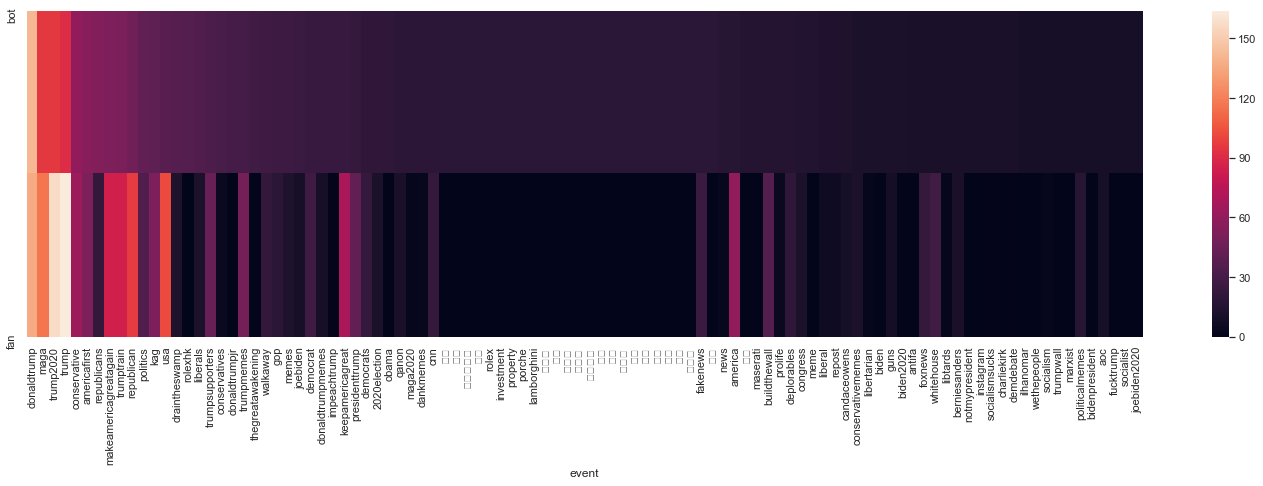

In [71]:
f, ax = plt.subplots(figsize =(25, 6)) 
ax = sns.heatmap( df_resutl_transposed_sort[df_resutl_transposed_sort.columns[:100]])

# load real users

In [90]:
# MongoDB Database
instagramClient = pymongo.MongoClient('127.0.0.1:27017',authSource='Instagram')
instagram_db = instagramClient["Instagram"]
instagram_col_post = instagram_db["Post_impersonator_m"]
instagram_col_comment = instagram_db["Comment_impersonator_m"]
instagram_col_like = instagram_db["Like_impersonator_m"]

df_post_d =  pd.DataFrame(list(instagram_col_post.find({ }) ))
df_post_d.shape[0]

426

In [91]:
df_post_r = pd.read_csv('Dataset/post_main_use_case.csv')
df_post_r.shape[0]

952

In [92]:
def convert_representations_to_real_list(_row):
    
    _row['post_caption_hashtags'] = ast.literal_eval(_row['post_caption_hashtags'])
#     _row['post_caption_mentions'] = ast.literal_eval(_row['post_caption_mentions'])

    return _row

df_post_r = df_post_r.apply(convert_representations_to_real_list, axis=1)

In [93]:
df_post_f = pd.concat([df_post_d, df_post_r])
df_post_f.shape[0]

/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


1378

In [94]:
# politician
df_post_trump = df_post_f.loc[( df_post_f['post_owner_username'] == vr.DONALD_TRUMP ) ] 
df_post_obama = df_post_f.loc[( df_post_f['post_owner_username'] == vr.BARACK_OBAMA ) ]
df_post_macron = df_post_f.loc[( df_post_f['post_owner_username'] == vr.EMMANUEL_MACRON ) ]
df_post_johnson = df_post_f.loc[( df_post_f['post_owner_username'] == vr.BORIS_JOHNSON ) ]
df_post_may = df_post_f.loc[( df_post_f['post_owner_username'] == vr.THERESA_MAY ) ]

# sport player
df_post_cristiano_ronalod = df_post_f.loc[( df_post_f['post_owner_username'] == vr.CRISTIANO_RONALDO ) ] 
df_post_leo_messi = df_post_f.loc[( df_post_f['post_owner_username'] == vr.LEOMESSI ) ]
df_post_roger_federer = df_post_f.loc[( df_post_f['post_owner_username'] == vr.ROGER_FEDERER ) ]
df_post_rafael_nadal = df_post_f.loc[( df_post_f['post_owner_username'] == vr.RAFAEL_NADAL ) ]
df_post_djokovic = df_post_f.loc[( df_post_f['post_owner_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_post_lady_gaga = df_post_f.loc[( df_post_f['post_owner_username'] == vr.LADY_GAGA )] 
df_post_beyonce = df_post_f.loc[( df_post_f['post_owner_username'] == 'beyonce' ) ] 
df_post_taylor_swift = df_post_f.loc[( df_post_f['post_owner_username'] == vr.TAYLOR_SWIFT ) ] 
df_post_adele = df_post_f.loc[( df_post_f['post_owner_username'] == vr.ADELE ) ] 
df_post_madonna = df_post_f.loc[( df_post_f['post_owner_username'] == vr.MADONNA ) ] 

In [95]:
df_post_madonna.columns

Index(['Unnamed: 0', '_id', 'post_caption', 'post_caption_hashtags',
       'post_caption_mentions', 'post_comments', 'post_date_utc',
       'post_is_video', 'post_likes', 'post_location', 'post_mediaid',
       'post_owner_biography', 'post_owner_external_url',
       'post_owner_followees', 'post_owner_followers', 'post_owner_full_name',
       'post_owner_id', 'post_owner_is_private', 'post_owner_is_verified',
       'post_owner_mediacount', 'post_owner_profile_pic_url',
       'post_owner_username', 'post_shortcode', 'post_tagged_users',
       'post_thumbnail', 'post_typename', 'post_url', 'post_video_url',
       'post_viewer_has_liked'],
      dtype='object')

In [107]:
def get_heatmap_plot(_df1, _df2, _df_main, _column_count):
    
    text_t = _df1['hashtag'].sum()
    counter=collections.Counter(text_t)
    df_t = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    df_t = df_t.rename(columns={'index':'event', 0:'fan'})
    df_t = df_t.sort_values(by=['fan'], ascending=False)
    df_t = df_t[:_column_count]


    text_t1 = _df2['hashtag'].sum()
    counter1=collections.Counter(text_t1)
    df_t1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index()
    df_t1 = df_t1.rename(columns={'index':'event', 0:'bot'})
    df_t1 = df_t1.sort_values(by=['bot'], ascending=False)
    df_t1 = df_t1[:_column_count]
    
    
    text_m = _df_main['post_caption_hashtags'].sum()
    counterm=collections.Counter(text_m)
    df_tm = pd.DataFrame.from_dict(counterm, orient='index').reset_index()
    df_tm = df_tm.rename(columns={'index':'event', 0:'real'})
    df_tm = df_tm.sort_values(by=['real'], ascending=False)
    df_tm = df_tm[:_column_count]
    
    #merg
    df_resutl = pd.merge(df_t, df_t1, how='outer', on=['event'])
    df_resutl = pd.merge(df_resutl, df_tm, how='outer', on=['event'])
    df_resutl.fillna(0, inplace=True)
    df_resutl = df_resutl.set_index("event")
    
    # sort
#     df_resutl_sort = df_resutl.sort_values(by=['bot'], ascending=False)
    
    # trasnpose
    df_resutl_transposed_sort = df_resutl.T
    
    return df_resutl_transposed_sort#[df_resutl_transposed_sort.columns[:_column_count]]

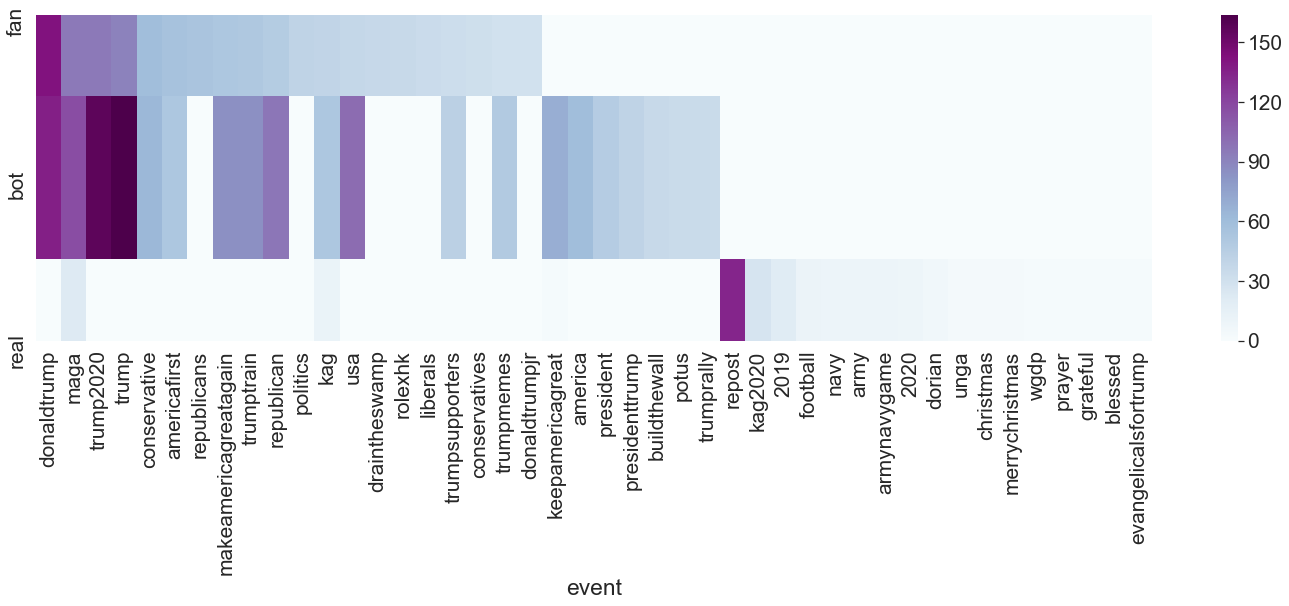

In [124]:
f, ax = plt.subplots(figsize =(25, 6)) 
sns.set(font_scale=1.9)
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_trump, extended_cluster_1_trump, df_post_trump, 20)  ,cmap="BuPu" )
plt.savefig("plot_18Cluster_P10.pdf", bbox_inches='tight')

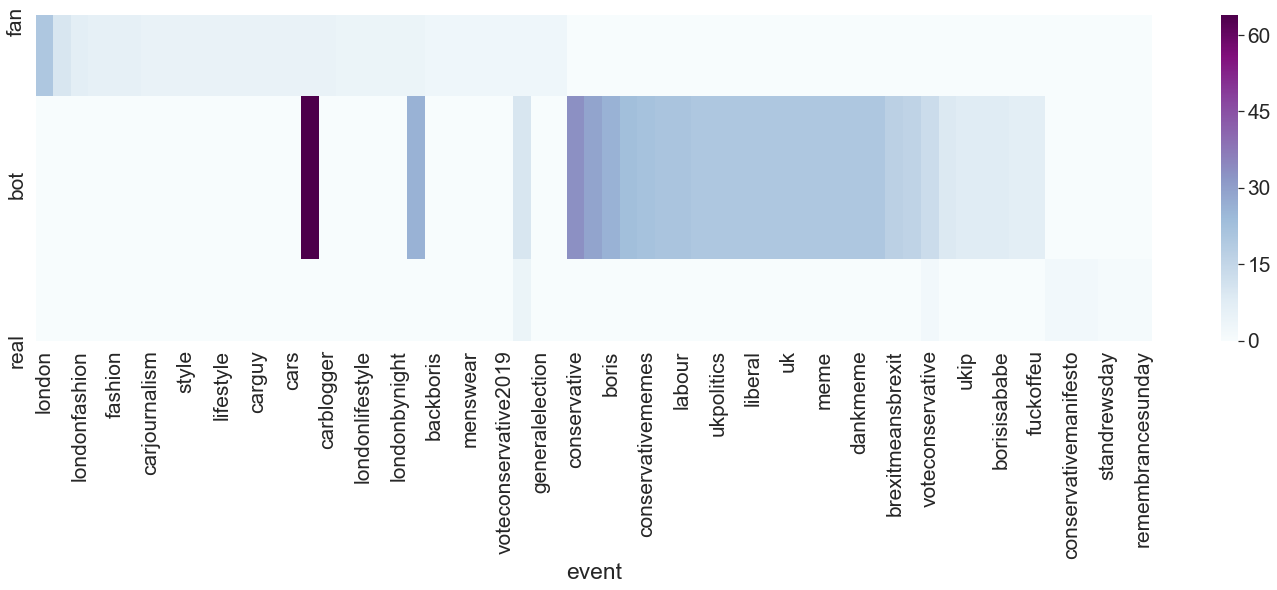

In [126]:
f, ax = plt.subplots(figsize =(25, 6)) 
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_johnson, extended_cluster_1_johnson, df_post_johnson, 30) ,cmap="BuPu" )
plt.savefig("plot_18Cluster_P11.pdf", bbox_inches='tight')

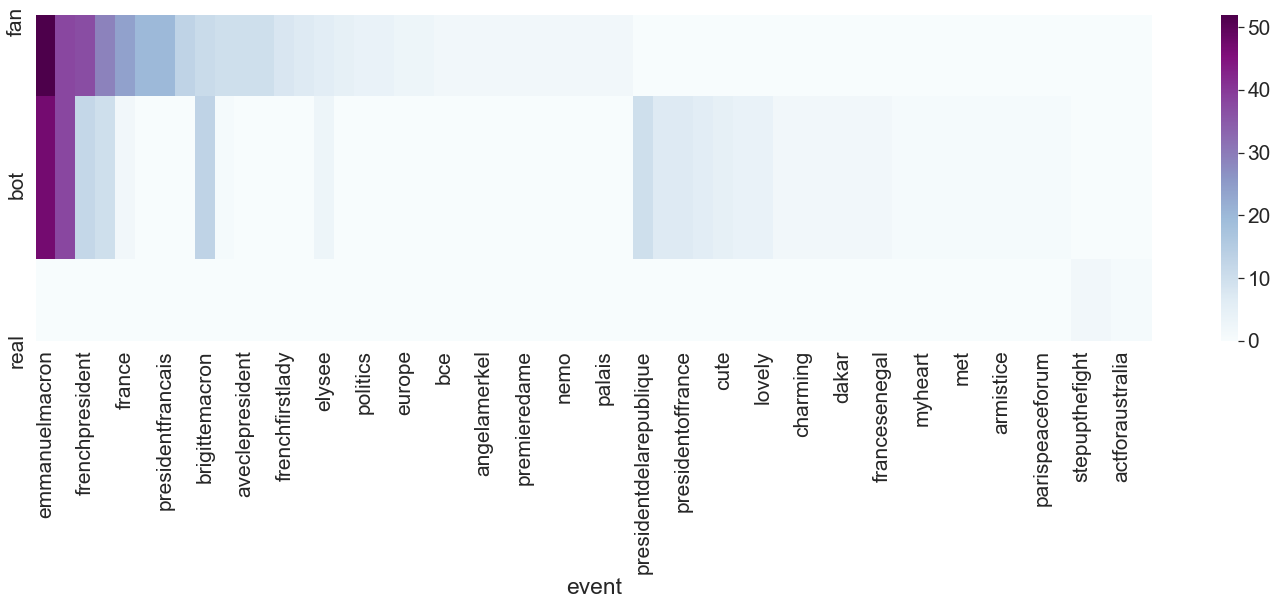

In [127]:
f, ax = plt.subplots(figsize =(25, 6)) 
sns.heatmap( get_heatmap_plot(extended_cluster_0_macron, extended_cluster_1_macron, df_post_macron, 30) ,cmap="BuPu" )

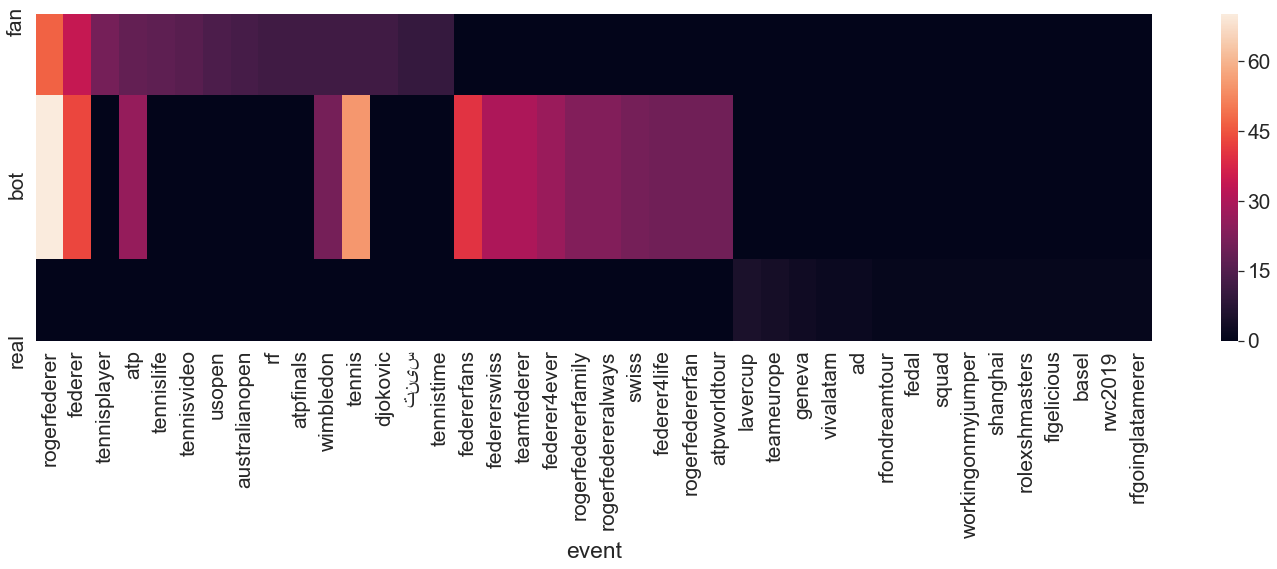

In [103]:
f, ax = plt.subplots(figsize =(25, 6)) 
sns.heatmap( get_heatmap_plot(extended_cluster_0_federer, extended_cluster_1_federer, df_post_roger_federer, 15)  )

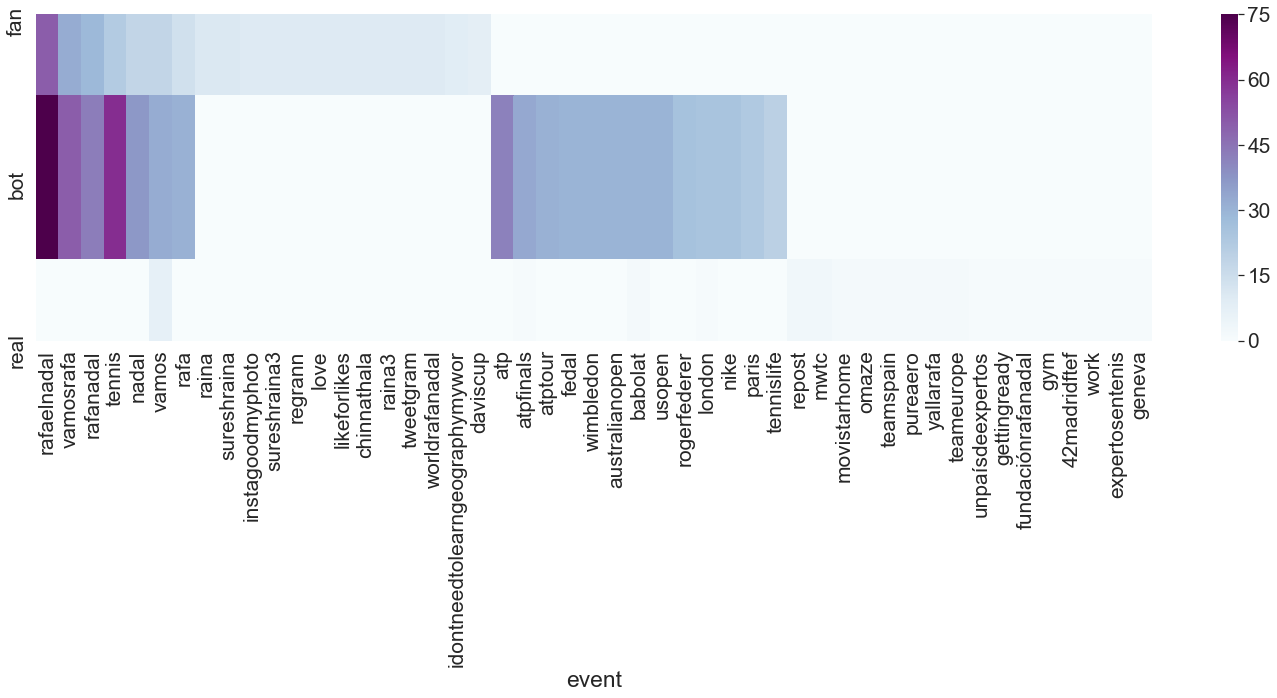

In [123]:
f, ax = plt.subplots(figsize =(25, 6)) 
sns.set(font_scale=1.9)
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_nadal, extended_cluster_1_nadal, df_post_rafael_nadal, 20)   ,cmap="BuPu")
plt.savefig("plot_18Cluster_P12.pdf", bbox_inches='tight')

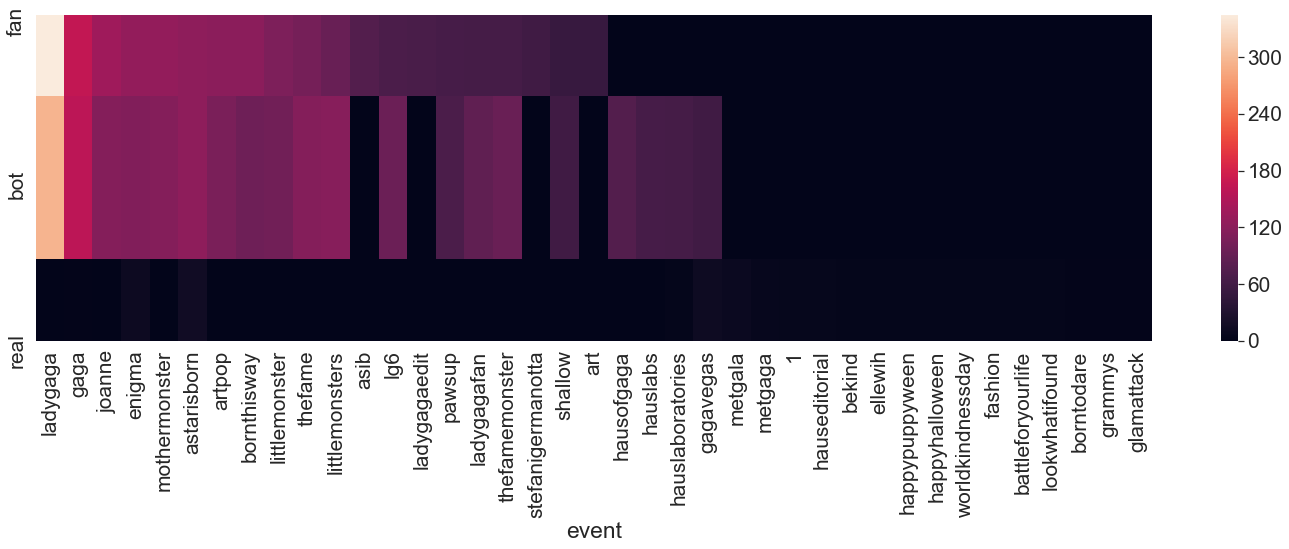

In [104]:
f, ax = plt.subplots(figsize =(25, 6)) 
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_ladygaga, extended_cluster_1_ladygaga, df_post_lady_gaga, 20)  )

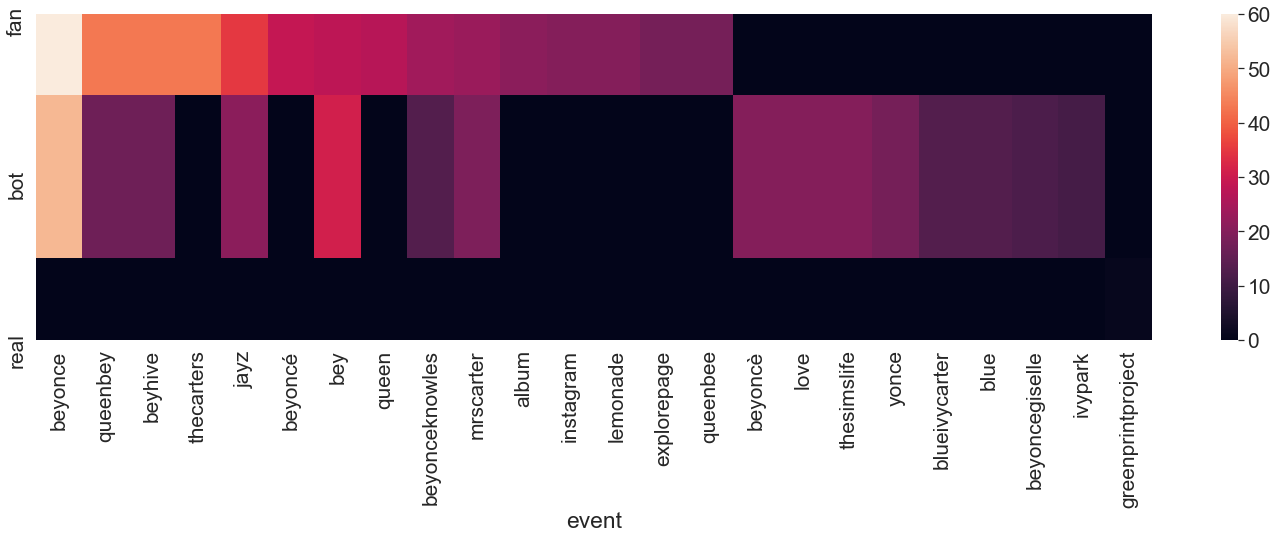

In [109]:
f, ax = plt.subplots(figsize =(25, 6)) 
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_beyonce, extended_cluster_1_beyonce, df_post_beyonce, 15)  )

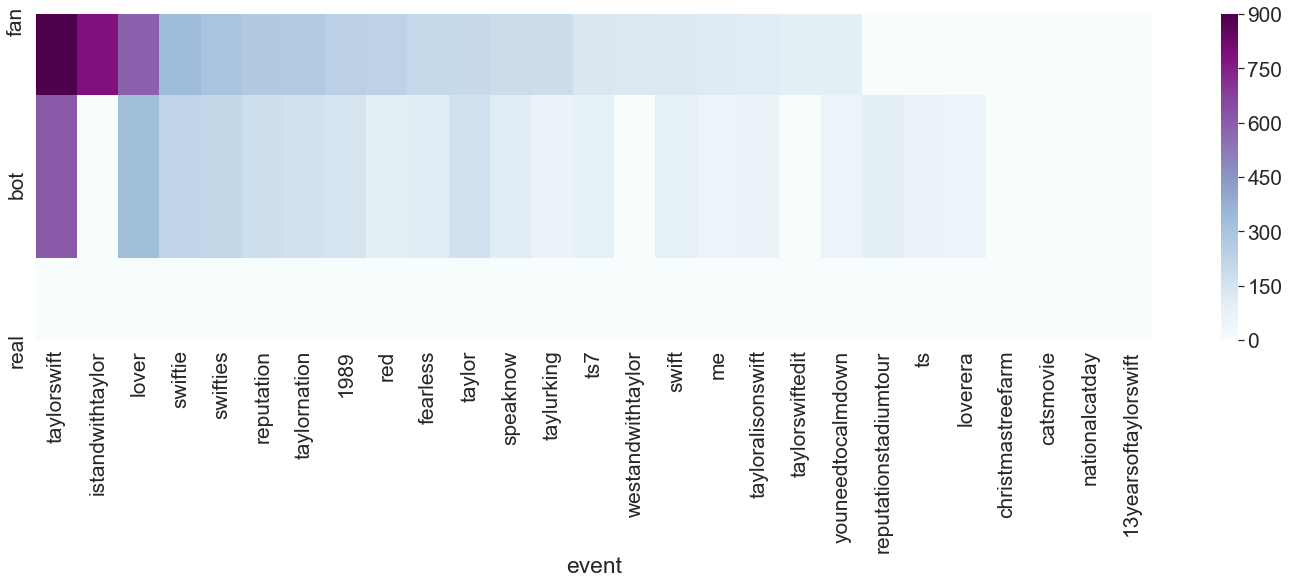

In [118]:
f, ax = plt.subplots(figsize =(25, 6)) 
ax = sns.heatmap( get_heatmap_plot(extended_cluster_0_taylorswift, extended_cluster_1_taylorswift,df_post_taylor_swift, 20) ,cmap="BuPu" )
plt.savefig("plot_18Cluster_P13.pdf", bbox_inches='tight')

/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36031 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kooshazarei/opt/anaconda3/li

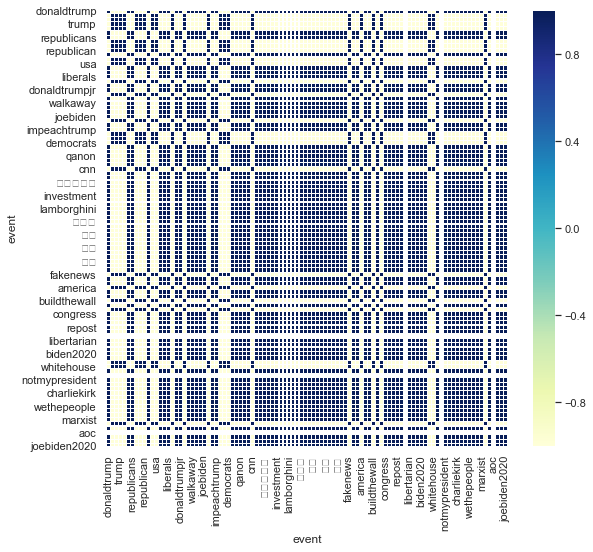

In [81]:
corrmat = df_resutl_transposed_sort[df_resutl_transposed_sort.columns[:100]].corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

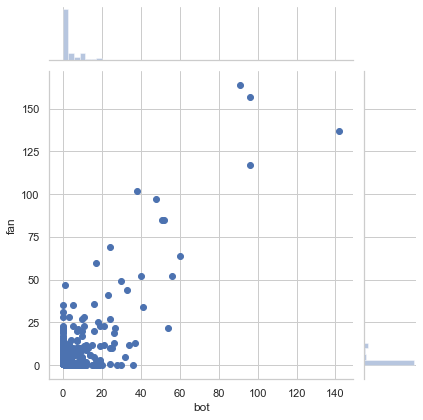

In [82]:
sns.jointplot(x="bot", y="fan", data=df_resutl)

In [83]:
flights = sns.load_dataset("flights")
flights
# flights = flights.pivot("month", "year", "passengers")
# ax = sns.heatmap(flights)

year      month  passengers
0    1949    January         112
1    1949   February         118
2    1949      March         132
3    1949      April         129
4    1949        May         121
..    ...        ...         ...
139  1960     August         606
140  1960  September         508
141  1960    October         461
142  1960   November         390
143  1960   December         432

[144 rows x 3 columns]

In [84]:
flights.pivot("month", "year", "passengers")

year       1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
month                                                                         
January     112   115   145   171   196   204   242   284   315   340   360   
February    118   126   150   180   196   188   233   277   301   318   342   
March       132   141   178   193   236   235   267   317   356   362   406   
April       129   135   163   181   235   227   269   313   348   348   396   
May         121   125   172   183   229   234   270   318   355   363   420   
June        135   149   178   218   243   264   315   374   422   435   472   
July        148   170   199   230   264   302   364   413   465   491   548   
August      148   170   199   242   272   293   347   405   467   505   559   
September   136   158   184   209   237   259   312   355   404   404   463   
October     119   133   162   191   211   229   274   306   347   359   407   
November    104   114   146   172   180   203   237   271   305   310   362   
December    118   140   166   194   201   229   278   306   336   337   405   

year       1960  
month            
January     417  
February    391  
March       419  
April       461  
May         472  
June        535  
July        622  
August      606  
September   508  
October     461  
November    390  
December    432